In [47]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

In [48]:
# Load dataset
# Ejecutar el siguiente comando para generar el archivo: featured_house_data.csv
# python src/features/engineer.py   --input data/processed/cleaned_house_data.csv   --output data/processed/featured_house_data.csv   --preprocessor models/trained/preprocessor.pkl
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Use RandomForest for RFE (más estable y sin dependencias externas)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# RFE with RandomForest
rfe_selector = RFE(estimator=rf_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE (using RandomForest):")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features),
    'rfe_method': 'RandomForestRegressor',
    'total_features': len(X.columns),
    'selected_features_count': len(rfe_selected_features)
}

print(f"\n📊 Feature Selection Summary:")
print(f"   Original features: {len(X.columns)}")
print(f"   Selected features: {len(rfe_selected_features)}")
print(f"   Reduction: {len(X.columns) - len(rfe_selected_features)} features removed")

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]

print(f"\n✅ Datasets filtered to use only selected features")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")

✅ Top 10 Selected Features by RFE (using RandomForest):
 - 0
 - 1
 - 2
 - 3
 - 4
 - 5
 - 6
 - 9
 - 11
 - 14

❌ Features Ignored by RFE:
 - 7
 - 8
 - 10
 - 12
 - 13
 - 15

📊 Feature Selection Summary:
   Original features: 16
   Selected features: 10
   Reduction: 6 features removed

✅ Datasets filtered to use only selected features
   X_train shape: (61, 10)
   X_test shape: (16, 10)


In [4]:
import mlflow


In [2]:
pip show mlflow


Name: mlflow
Version: 2.22.1
Summary: MLflow is an open source platform for the complete machine learning lifecycle
Home-page: https://mlflow.org
Author: 
Author-email: 
License: Copyright 2018 Databricks, Inc.  All rights reserved.

                                Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the

In [5]:
import mlflow

mlflow_tracking_uri = "http://127.0.0.1:5555"

if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)

mlflow.set_experiment("House Price Prediction Experiment")


2025/08/02 19:25:35 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/tmp/mlruns/1', creation_time=1754180735322, experiment_id='1', last_update_time=1754180735322, lifecycle_stage='active', name='House Price Prediction Experiment', tags={}>

In [6]:
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")

In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'HistGradientBoosting': HistGradientBoostingRegressor()
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [None, 5, 10, 15, 20, 25],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'GradientBoosting': {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.8, 0.9, 1.0]
    },
    
    'HistGradientBoosting': {
        'max_iter': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 5, 7, 10, None],
        'l2_regularization': [0.0, 0.1, 0.5, 1.0]
    }
}


In [8]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://127.0.0.1:5555


In [9]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el dataset
data = pd.read_csv('../data/processed/featured_house_data.csv')
X = data.drop('price', axis=1)
y = data['price']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
print(X_train.shape, y_train.shape)


(61, 16) (61,)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [14]:
# ML imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [15]:
results = {}

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


INFO:__main__:Training LinearRegression...
2025/08/02 19:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:Training RandomForest...


LinearRegression R2: 0.9901, RMSE: 21429.17
🏃 View run LinearRegression at: http://127.0.0.1:5555/#/experiments/1/runs/9c9de688ed56481f8e5f322c8d5e7f88
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


2025/08/02 19:26:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:Training GradientBoosting...


RandomForest R2: 0.9944, RMSE: 16220.37
🏃 View run RandomForest at: http://127.0.0.1:5555/#/experiments/1/runs/417a0bec1c084189bb0da79a847e0c3b
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


2025/08/02 19:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:__main__:Training HistGradientBoosting...


GradientBoosting R2: 0.9748, RMSE: 34255.17
🏃 View run GradientBoosting at: http://127.0.0.1:5555/#/experiments/1/runs/46c8ccda964e45988edf8067f89c3473
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


2025/08/02 19:26:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


HistGradientBoosting R2: 0.8235, RMSE: 90671.01
🏃 View run HistGradientBoosting at: http://127.0.0.1:5555/#/experiments/1/runs/ba6e8744ca164eccbdf73e462b565290
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1
🏃 View run model_comparison at: http://127.0.0.1:5555/#/experiments/1/runs/f4418ad2931b41d685b2dd6659736125
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


In [16]:
import matplotlib.pyplot as plt


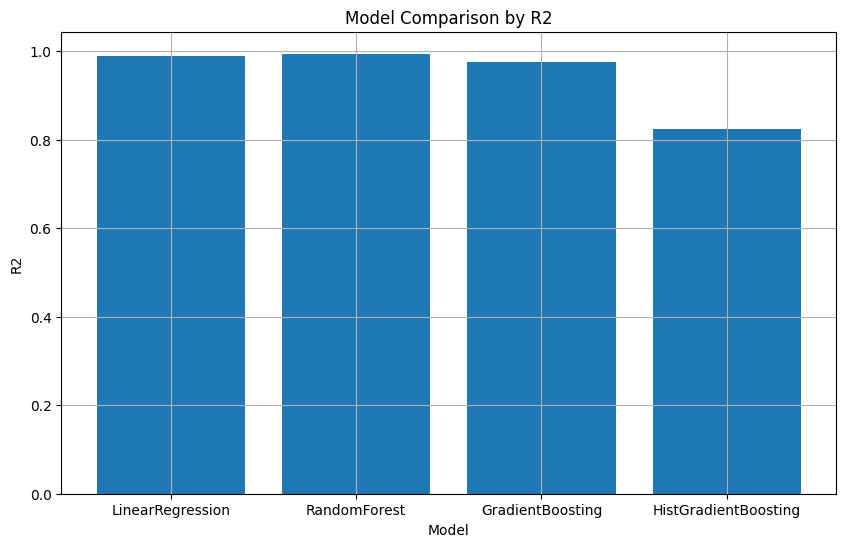

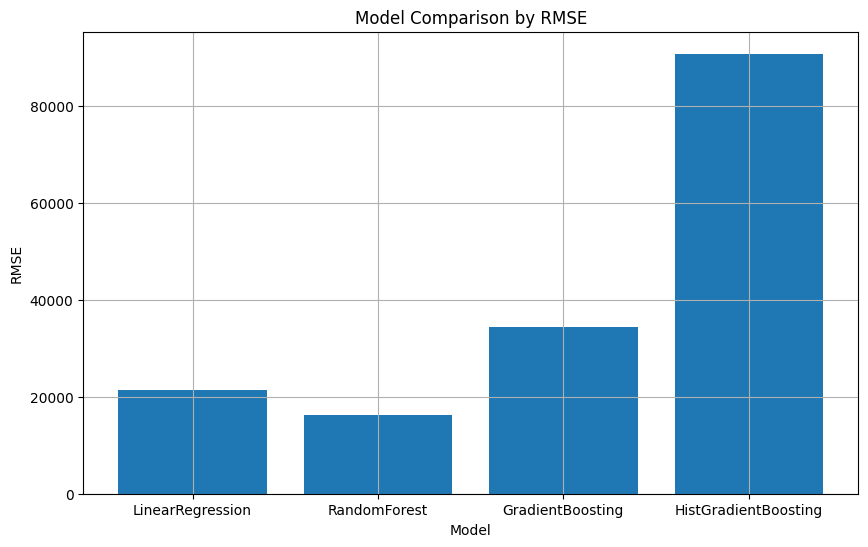

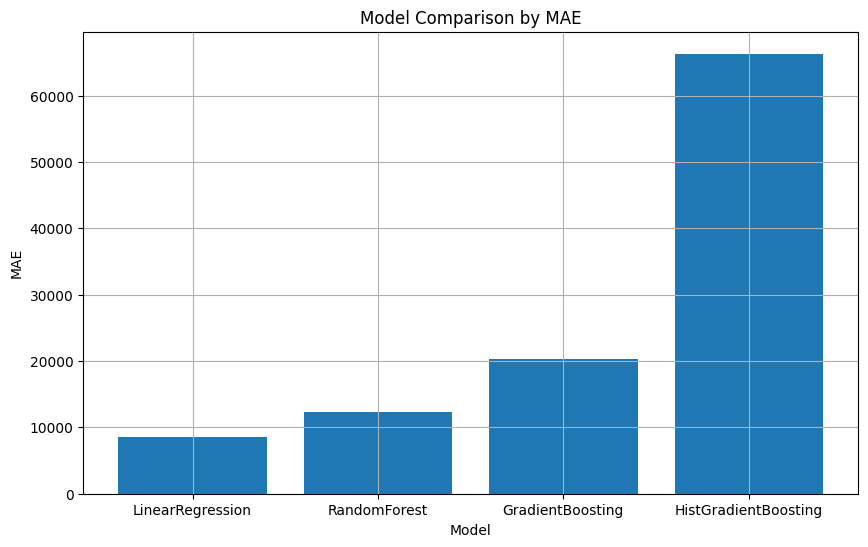

In [17]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [19]:
import os
import yaml

# Supongamos que estas son las características seleccionadas
selected_features = ['sqft_living', 'bedrooms', 'bathrooms', 'grade', 'view']
selected_features_dict = {'selected_features': selected_features}

# Obtener el mejor modelo según R²
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

# Mostrar resultados
print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

# Crear diccionario de configuración
model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'rmse': best_rmse,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

# Guardar en archivo YAML
config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"✅ Saved model config to {config_path}")


🏆 Best Model: RandomForest
   R² Score: 0.9944
   MAE: 12322.50
   RMSE: 16220.37
✅ Saved model config to ../configs/model_config.yaml


In [20]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:5555")
mlflow.set_experiment("House Price Prediction Experiment")

with mlflow.start_run():
    mlflow.log_param("model_name", best_model_name)
    mlflow.log_params(best_params)
    mlflow.log_metric("r2_score", best_r2)
    mlflow.log_metric("mae", best_mae)
    mlflow.log_metric("rmse", best_rmse)
    
    # Loguear el modelo como artefacto
    mlflow.sklearn.log_model(best_model, "model")
    
    # Loguear el archivo YAML como artefacto
    mlflow.log_artifact(config_path)


2025/08/02 19:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sneaky-gnu-989 at: http://127.0.0.1:5555/#/experiments/1/runs/d8b3dec879f64b0c91d25ce0ebfcea7f
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


In [21]:
import joblib

model_path = "../artifacts/best_model.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(best_model, model_path)
print(f"✅ Modelo guardado en {model_path}")


✅ Modelo guardado en ../artifacts/best_model.pkl


In [22]:
mlflow.log_artifact(model_path)


In [23]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="http://localhost:5555")

model_name = "house_price_model"
model_version = "1"

# Promover a producción
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Production",
    archive_existing_versions=True  # Opcional: archiva versiones anteriores
)

# Confirmar alias
client.set_registered_model_alias(
    name=model_name,
    alias="production",
    version=model_version
)

print(f"✅ Modelo {model_name} versión {model_version} promovido a 'Production'")


✅ Modelo house_price_model versión 1 promovido a 'Production'


C:\Users\Usuario\AppData\Local\Temp\ipykernel_11168\3164707432.py:10: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
